# Import libraries & define constants

In [6]:
RUNTIME = 0

In [7]:
import seaborn as sns
from math import sqrt, ceil
import os
from os import listdir
import shutil
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import SGD
from keras.regularizers import l1
from keras_preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras import applications, Model

DATASET_PATH = "../res/dataset/"
MODEL_PARAM_DIR = "../res/model_param/"
LOAD = True
LOAD_MODEL = True
SAVE_CP = False

if RUNTIME==1:
    DATASET_PATH = "/content/ds_unzipped/chest_xray/chest_xray/"
    MODEL_PARAM_DIR = "/content/drive/My Drive/Colab Notebooks/Project/res/weights/"
    LOAD = False
elif RUNTIME==2:
    DATASET_PATH = "../input/chest-xray-pneumonia/chest_xray/chest_xray/"
    MODEL_PARAM_DIR = ""
    LOAD = False

PATHS = {"train": DATASET_PATH+"train/", "val": DATASET_PATH+"val/", "test": DATASET_PATH+"test/"}
#path_labels = {"normal": "NORMAL/", "pneumonia": "PNEUMONIA/", "bacteria": "BACTERIA/", "virus": "VIRUS/", }

LABELS = [item.lower() for item in os.listdir(PATHS["train"])]

SEED = 42

SHUFFLE = False # only for confusion matrix
COLOR_MODE = 'rgb'
CLASS_MODE = "binary" #or 'categorical'
RESCALE = 1./255
ROTATION_RANGE = 15
WIDTH_SHIFT_RANGE = 0.2
HEIGHT_SHIFT_RANGE = 0.2
SHEAR_RANGE = 0.15
ZOOM_RANGE=0.2
HORIZONTAL_FLIP = True
FILL_MODE = "nearest"
INPUT_SHAPE = (256, 256, 1)
if tf.keras.backend.image_data_format() == 'channels_first':
    INPUT_SHAPE = (INPUT_SHAPE[-1], INPUT_SHAPE[0], INPUT_SHAPE[1])
INPUT_SHAPE3 = INPUT_SHAPE[0:2]+(3,)
if tf.keras.backend.image_data_format() == 'channels_first':
    INPUT_SHAPE3 = (INPUT_SHAPE3[-1], INPUT_SHAPE3[0], INPUT_SHAPE3[1])

POOL_SIZE = (2,2)
KERNEL_SIZE = (3,3)
ACTIVATION_HIDDEN_LAYERS = 'relu'
ACTIVATION_OUTPUT_LAYER = 'sigmoid' #or 'softmax'
DROPOUT = 0.5
OUTPUT_NEURONS = 1 #or 3

LOSS = 'binary_crossentropy' #or 'categorical_crossentropy'
OPTIMIZER = 'adam'
METRICS = ['accuracy']
BATCH_SIZE = 16
EPOCHS = 50
    
WEIGHTS = "imagenet"

UNFREEZED = 11 # 15 for last block
LR = 1e-4
MOMENTUM = 0.9
REGULARIZER = l1(1e-3)

# Load the data

In [8]:
def separate_pneuomia_classes(dir):
    #label_dir = {"pneumonia": dir+path_labels["pneumonia"], "bacteria": dir+path_labels["bacteria"], "virus": dir+path_labels["virus"]}
    label_dir = ""
    
    if os.path.exists(label_dir["bacteria"]) or os.path.exists(label_dir["virus"]):
        return
    else:
        os.mkdir(label_dir["bacteria"])
        os.mkdir(label_dir["virus"])
    
    for f in listdir(label_dir["pneumonia"]):
        shutil.move(label_dir["pneumonia"]+f, label_dir["virus"] if "virus" in f else label_dir["bacteria"])
        
    shutil.rmtree(label_dir["pneumonia"])

np.random.seed(SEED)
if RUNTIME==1: # Fix (difference between tf2.0 and tf1.5 (this one in Colab))
    tf.set_random_seed(SEED)
else:   
    tf.random.set_seed(SEED)
 
#separate_pneuomia_classes(PATHS["train"])
#separate_pneuomia_classes(PATHS["val"])
#separate_pneuomia_classes(PATHS["test"])

train_datagen = ImageDataGenerator(rescale=RESCALE, shear_range=SHEAR_RANGE, zoom_range=ZOOM_RANGE, rotation_range=ROTATION_RANGE)
#train_datagen = ImageDataGenerator(rescale=RESCALE, rotation_range=ROTATION_RANGE, width_shift_range=WIDTH_SHIFT_RANGE, height_shift_range=HEIGHT_SHIFT_RANGE, horizontal_flip=HORIZONTAL_FLIP, shear_range=SHEAR_RANGE, fill_mode=FILL_MODE)
test_datagen = ImageDataGenerator(rescale=RESCALE)

train_generator = train_datagen.flow_from_directory(PATHS["train"], target_size = INPUT_SHAPE3[0:2], batch_size=BATCH_SIZE, color_mode=COLOR_MODE, class_mode=CLASS_MODE, seed=SEED, shuffle=SHUFFLE)
val_generator = test_datagen.flow_from_directory(PATHS["val"], target_size = INPUT_SHAPE3[0:2], batch_size=BATCH_SIZE, color_mode=COLOR_MODE, class_mode=CLASS_MODE, seed=SEED, shuffle=SHUFFLE)
test_generator = test_datagen.flow_from_directory(PATHS["test"], target_size = INPUT_SHAPE3[0:2], batch_size=BATCH_SIZE, color_mode=COLOR_MODE, class_mode=CLASS_MODE, seed=SEED, shuffle=SHUFFLE)
image_count = {"train": len(train_generator.filenames), "val": len(val_generator.filenames), "test": len(test_generator.filenames)}
steps_per_epoch = {"train": np.ceil(image_count["train"]/BATCH_SIZE), "val": np.ceil(image_count["val"]/BATCH_SIZE), "test": np.ceil(image_count["test"]/BATCH_SIZE)}
num_elem_for_class_train = {"normal": len(os.listdir(PATHS["train"]+"/NORMAL")), "pneumonia": len(os.listdir(PATHS["train"]+"/PNEUMONIA"))}
num_elem_for_class_train

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


{'normal': 1341, 'pneumonia': 3875}

# Utils

## Show batch

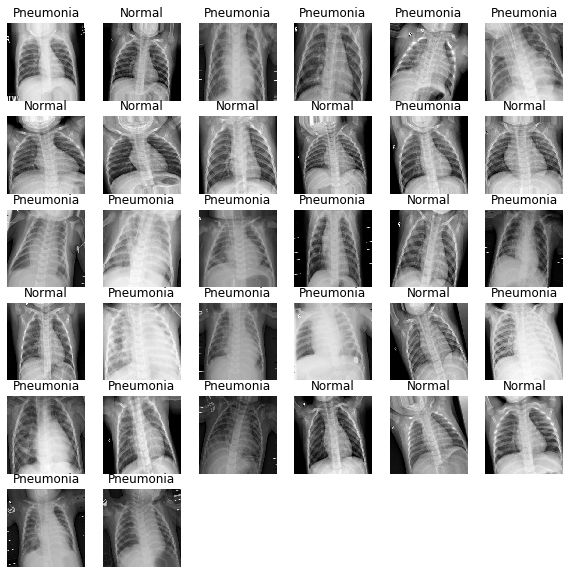

In [3]:
def show_batch(image_batch, label_batch, size):
    figsize = (10,10)
    cmap = "gray"
    axis = "off"
    
    plt.figure(figsize=figsize)
    rows_cols = ceil(sqrt(size))
  
    for n in range(size):
        ax = plt.subplot(rows_cols,rows_cols,n+1)
        plt.imshow(image_batch[n][:,:,0], cmap=cmap)
        #plt.title(LABELS[(label_batch[n]==1).tolist().index(True)]) # what was for multiclass? 
        plt.title(LABELS[0].capitalize() if label_batch[n]==1 else LABELS[1].capitalize())
        plt.axis(axis)
      
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch, BATCH_SIZE)

## Plot learning

In [4]:
def plot_learning(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.figure()
    
    # Plot training and validation loss per epoch
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')

## Load and save function

In [5]:
def load_save(name, model):
    callbacks = []
    reduce_learning_rate = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, cooldown=2, min_lr=1e-5,verbose=1)
    callbacks.append(reduce_learning_rate)
    
    es = EarlyStopping(patience=5)
    #callbacks.append(es)
    
    if SAVE_CP:
        filepath = MODEL_PARAM_DIR+"model_"+NAME+"-{epoch:02d}.h5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
        callbacks.append(checkpoint)
        
    if LOAD:
        if LOAD_MODEL:    
            model = load_model(MODEL_PARAM_DIR+"model_"+name+'.h5')
        else:
            model.load_weights(MODEL_PARAM_DIR+"weights_"+name+'.h5')
            
        model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    else:
        model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
        if SAVE_CP: 
            history = model.fit_generator(train_generator, validation_data=val_generator, epochs=EPOCHS, steps_per_epoch=steps_per_epoch["train"], validation_steps=steps_per_epoch["val"], callbacks=callbacks)
        else:
            history = model.fit_generator(train_generator, validation_data=val_generator, epochs=EPOCHS, steps_per_epoch=steps_per_epoch["train"], validation_steps=steps_per_epoch["val"], callbacks=callbacks)
            
        plot_learning(history)
        
        model.save(MODEL_PARAM_DIR+"model_"+name+'.h5')
        model.save_weights(MODEL_PARAM_DIR+"weights_"+name+'.h5')

    return model

# Model

## Simple CNN

In [6]:
NAME = "simple"

model = Sequential()

model.add(Conv2D(32, KERNEL_SIZE, input_shape=INPUT_SHAPE3))
model.add(Activation(ACTIVATION_HIDDEN_LAYERS))
model.add(MaxPooling2D(pool_size=POOL_SIZE))

model.add(Conv2D(32, KERNEL_SIZE))
model.add(Activation(ACTIVATION_HIDDEN_LAYERS))
model.add(MaxPooling2D(pool_size=POOL_SIZE))

model.add(Conv2D(64, KERNEL_SIZE))
model.add(Activation(ACTIVATION_HIDDEN_LAYERS))
model.add(MaxPooling2D(pool_size=POOL_SIZE))

model.add(Flatten()) # converts 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation(ACTIVATION_HIDDEN_LAYERS))
model.add(Dropout(DROPOUT))
model.add(Dense(OUTPUT_NEURONS))
model.add(Activation(ACTIVATION_OUTPUT_LAYER))

model = load_save(NAME, model)

val_score = model.evaluate_generator(val_generator, steps_per_epoch["val"])
test_score = model.evaluate_generator(test_generator, steps_per_epoch["test"])
#predict = model.predict_generator(test_generator, steps=steps_per_epoch["test"])

print(val_score)
print(test_score)

[0.7331153154373169, 0.625]
[0.4380406141281128, 0.7788461446762085]


## Transfer learning (VGG16)

### Transfer learning (VGG16) freeze 1

In [9]:
NAME = "vgg16_freeze1"

#def gray_to_rgb(img):
#    return np.repeat(img, 3, 2)

#datagen = ImageDataGenerator(rescale=RESCALE, preprocessing_function=gray_to_rgb)

vgg16 = applications.VGG16(weights=WEIGHTS, include_top=False, input_shape=INPUT_SHAPE3)

for layer in vgg16.layers:
    layer.trainable=False
    
# vgg16.summary()

model = Sequential([
    vgg16,
    
    Flatten(),
    Dense(512, activation=ACTIVATION_HIDDEN_LAYERS),
    BatchNormalization(),
    Dropout(DROPOUT),
    
    Dense(64, activation=ACTIVATION_HIDDEN_LAYERS),
    BatchNormalization(),
    Dropout(DROPOUT),
    
    Dense(OUTPUT_NEURONS, activation=ACTIVATION_OUTPUT_LAYER)
])

# model.summary()

model = load_save(NAME, model)

val_score = model.evaluate_generator(val_generator, steps_per_epoch["val"])
test_score = model.evaluate_generator(test_generator, steps_per_epoch["test"])

print(val_score)
print(test_score)

KeyboardInterrupt: 

### Transfer learning (VGG16) fine-tuning

#### Freeze

In [6]:
NAME = "vgg16_freeze2_before"

OPTIMIZER = SGD(lr=LR, momentum=MOMENTUM)

# load the VGG16 network, ensuring the head FC layer sets are left off
base_model = applications.VGG16(weights=WEIGHTS, include_top=False, input_shape=INPUT_SHAPE3)
 
# construct the head of the model that will be placed on top of the the base model
headModel = base_model.output
headModel = Flatten()(headModel)
#headModel = Dense(512, activation=ACTIVATION_HIDDEN_LAYERS, activity_regularizer=REGULARIZER)(headModel)
headModel = Dense(512, activation=ACTIVATION_HIDDEN_LAYERS)(headModel)
headModel = Dropout(DROPOUT)(headModel)
headModel = Dense(OUTPUT_NEURONS, activation=ACTIVATION_OUTPUT_LAYER)(headModel)
 
# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=base_model.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in base_model.layers:
	layer.trainable = False

model = load_save(NAME, model)

val_score = model.evaluate_generator(val_generator, steps_per_epoch["val"])
test_score = model.evaluate_generator(test_generator, steps_per_epoch["test"])

print(val_score)
print(test_score)

KeyboardInterrupt: 

#### Unfreeze

In [9]:
NAME = "vgg16_freeze2_after"

# reset our data generators
train_generator.reset()
val_generator.reset()
test_generator.reset()
 
# now that the head FC layers have been trained/initialized, lets unfreeze the final set of CONV layers and make them trainable
for layer in base_model.layers[UNFREEZED:]:
	layer.trainable = True

model = load_save(NAME, model)

val_score = model.evaluate_generator(val_generator, steps_per_epoch["val"])
test_score = model.evaluate_generator(test_generator, steps_per_epoch["test"])

print(val_score)
print(test_score)

[0.2058732509613037, 0.875]
[0.6618144512176514, 0.8365384340286255]


# Conf matrix and balance diagram

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

true = test_generator.classes
pred = model.predict_generator(test_generator, steps=steps_per_epoch["test"])
y_pred = pred > 0.5 #or y_pred = np.argmax(pred, axis=-1)

cm = confusion_matrix(true, y_pred)

tn, fp, fn, tp = cm.ravel()
specificity = tn/(tn+fp)*100
#print(specificity)

plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

print(classification_report(true, y_pred))

NameError: name 'model' is not defined

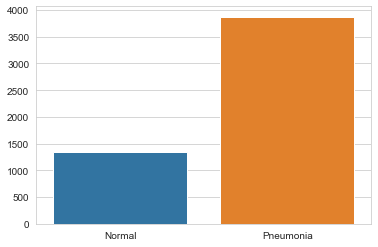

In [18]:
sns.set_style('whitegrid')
sns.barplot(x=['Normal','Pneumonia'],y=[num_elem_for_class_train["normal"], num_elem_for_class_train["pneumonia"]])

# Test

In [ ]:
from keras.preprocessing import image

img = image.load_img('flower.jpeg', target_size=(256, 256))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x/= 255.

images = np.vstack([x])
classes = model.predict(images)
print("Probability: {}, class (False for class 0 (normal), True for class 1 (pneumonia)): {}".format(classes[0], classes[0]>0.5))

plt.imshow(x[0])                           
plt.axis('off')
plt.show()